In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict, Counter
import random

In [79]:
def show(data, query, neighbors, y=None, title="Visualization"):

    plt.scatter(data[:, 0], data[:, 1], c=y, label="Data Points")
    plt.scatter(query[0], query[1], color='red', label="Query Point")
    
    neighbors = np.array(neighbors)
    # plt.scatter(neighbors[:, 0], neighbors[:, 1], marker="o", color='blue', label="Nearest Neighbors")
    plt.scatter(neighbors[:, 0], neighbors[:, 1], marker="o", edgecolor='blue', s=50, linewidth=2, facecolor='none',label="Nearest Neighbors") 
    
    plt.legend()
    plt.title(title)
    plt.show()


In [55]:
def knn_naive(data, y, query, k):
    distances = []
    for point, val in zip(data, y):
        distance = np.linalg.norm(np.array(query) - np.array(point))
        distances.append((distance, point, val))
        
    # Sort by distance and get the k closest neighbors
    distances.sort(key=lambda x: x[0])
    nearest_neighbors=[]
    labels=[]
    for _, point, label in distances[:k]:
        nearest_neighbors.append(point)
        labels.append(label)
    
    # Predict the most common label among nearest neighbors
    pred = stats.mode(labels)[0]
    
    return nearest_neighbors, pred

In [56]:
class LSH:
    def __init__(self, data, labels, num_planes=10):
        self.data = data
        self.labels = labels
        self.num_planes = num_planes  # Number of hyperplanes for hashing
        self.num_dimensions = data.shape[1]  # Dimensionality of data
        self.hash_table = defaultdict(list)
        self.hyperplanes = np.random.randn(num_planes, self.num_dimensions)
        self._hash_data()

    def _hash_data(self):
        # Hash each data point and store in hash table
        for idx, (point, label) in enumerate(zip(self.data, self.labels)):
            hash_key = self._compute_hash(point)
            self.hash_table[hash_key].append((tuple(point), label))

    def _compute_hash(self, point):
        # Compute hash key by projecting onto hyperplanes
        return ''.join(['1' if np.dot(point, plane) >= 0 else '0' for plane in self.hyperplanes])

    def knn_lsh(self, query, k):
        # Compute the hash for the query
        hash_key = self._compute_hash(query)
        
        # Retrieve candidate neighbors from the same hash bucket
        candidates = self.hash_table.get(hash_key, [])
        
        # If no candidates found, fallback to all data points (unlikely with good hashing)
        if not candidates:
            candidates = [(tuple(point), label) for point, label in zip(self.data, self.labels)]
        
        # Compute distances for candidates
        distances = [(np.linalg.norm(np.array(query) - np.array(candidate[0])), candidate[0], candidate[1]) 
                     for candidate in candidates]
        
        # Sort distances and get the k closest neighbors
        distances.sort(key=lambda x: x[0])
        nearest_neighbors = [point for _, point, label in distances[:k]]
        labels = [label for _, point, label in distances[:k]]
        
        # Determine predicted label by majority vote
        predicted_label = stats.mode(labels)[0]
        
        return nearest_neighbors, predicted_label

In [ ]:
class KDTreeNode:
    def __init__(self, point=None, label=None, left=None, right=None, is_leaf=False):
        self.point = point
        self.label = label
        self.left = left
        self.right = right
        self.is_leaf = is_leaf
        self.points = []  # Store points for leaf nodes if it's a leaf

class KDTree:
    def __init__(self, data, labels, leaf_size=40):
        # Combine data and labels into a single list of tuples
        data_with_labels = [(point, label) for point, label in zip(data, labels)]
        self.leaf_size = leaf_size
        self.root = self._build_tree(data_with_labels, depth=0)

    def _build_tree(self, data, depth=0):
        if len(data) <= self.leaf_size:
            # Make a leaf node and store all points in this leaf
            leaf_node = KDTreeNode(is_leaf=True)
            leaf_node.points = data
            return leaf_node
        
        k = len(data[0][0])  # Dimension of data points
        axis = depth % k
        data.sort(key=lambda x: x[0][axis])  # Sort by the current axis using points
        median = len(data) // 2

        # Recursively build left and right subtrees
        return KDTreeNode(
            point=data[median][0],
            label=data[median][1],
            left=self._build_tree(data[:median], depth + 1),
            right=self._build_tree(data[median + 1:], depth + 1)
        )

    def knn_kdtree(self, query, k):
        # Perform the KNN search with optimizations
        best = []
        self._knn_search(self.root, query, k, best, 0)
        best.sort(key=lambda x: x[0])
        
        # Gather neighbors and predict label based on majority vote
        nearest_neighbors = [point for _, point, label in best[:k]]
        labels = [label for _, point, label in best[:k]]
        predicted_label = stats.mode(labels)[0]
        
        return nearest_neighbors, predicted_label

    def _knn_search(self, node, query, k, best, depth):
        if not node:
            return
        
        # If it's a leaf node, evaluate all points in this leaf
        if node.is_leaf:
            for point, label in node.points:
                dist = np.linalg.norm(np.array(query) - np.array(point))
                if len(best) < k or dist < best[-1][0]:
                    best.append((dist, point, label))
                    best.sort(key=lambda x: x[0])
                    if len(best) > k:
                        best.pop()
            return
        
        # Calculate distance to the current node's point
        dist = np.linalg.norm(np.array(query) - np.array(node.point))
        if len(best) < k or dist < best[-1][0]:
            best.append((dist, node.point, node.label))
            best.sort(key=lambda x: x[0])
            if len(best) > k:
                best.pop()
        
        # Determine which branch to explore based on the splitting axis
        axis = depth % len(query)
        next_branch = node.left if query[axis] < node.point[axis] else node.right
        opposite_branch = node.right if next_branch == node.left else node.left

        # Explore the next branch
        self._knn_search(next_branch, query, k, best, depth + 1)
        
        # Check if we need to explore the opposite branch
        if len(best) < k or abs(query[axis] - node.point[axis]) < best[-1][0]:
            self._knn_search(opposite_branch, query, k, best, depth + 1)


In [82]:
np.random.seed(2)
data = np.random.rand(400, 2)
y=[0]*400
query = np.random.rand(2)  # Random query point
k = 4  # Number of nearest neighbors

In [83]:
lsh = LSH(data,y)
nearest_neighbors_lsh,p_l = lsh.knn_lsh(query, k)
nearest_neighbors_naive,p_n = knn_naive(data,y, query, k)

data_with_labels = [(point, label) for point, label in zip(data, y)]

# kdtree = KDTree(data_with_labels)
kdtree = KDTree(data, y)
nearest_neighbors_kdtree,p_t = kdtree.knn_kdtree(query, k)
print(nearest_neighbors_kdtree,p_t)

[array([0.66220202, 0.38752343]), array([0.68206786, 0.38362915]), array([0.70487486, 0.43073796]), array([0.69662112, 0.38763905])] 0


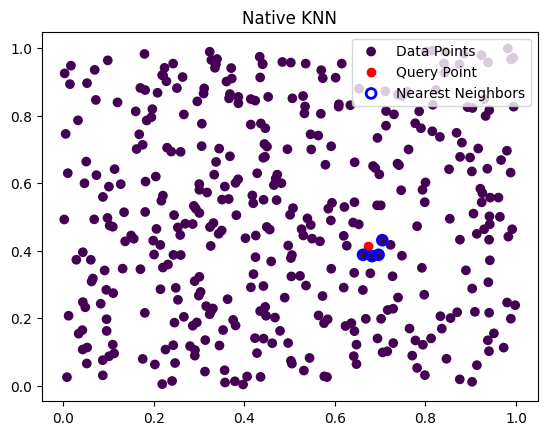

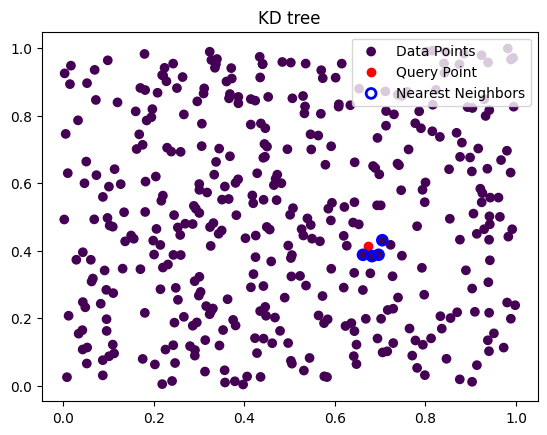

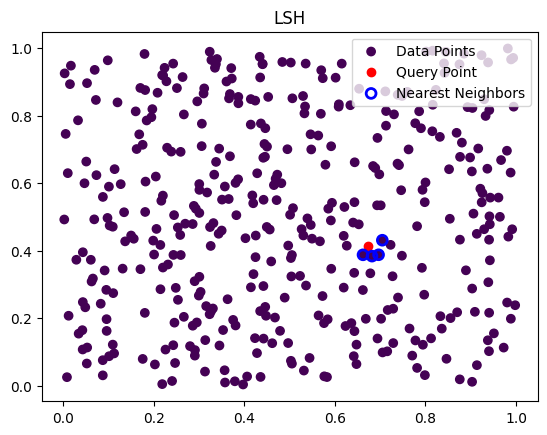

In [84]:
show(data,query,nearest_neighbors_naive,y,"Native KNN")
show(data,query,nearest_neighbors_kdtree,y,"KD tree")
show(data,query,nearest_neighbors_lsh,y, "LSH")

Naive k-NN might be accurate but slow.
<br>
LSH could be faster but approximate; tweaking num_hashes and num_planes can improve its accuracy.
<br>
KD-tree is efficient for lower-dimensional data but less efficient for higher dimensions.

In [67]:
from sklearn.datasets import make_blobs
import numpy as np

In [108]:
data = make_blobs(n_samples=200,n_features=2,centers=7,random_state=42)
x,y = data
# x = x+np.random.normal(loc=0,scale=3,size=x.shape)
# x[:5],y


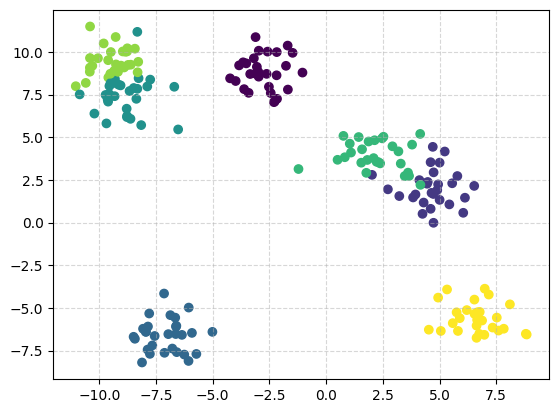

In [109]:
plt.scatter(x[:,0],x[:,1],c=y)
plt.grid(linestyle="--",alpha=.5)

In [73]:
data = x
query = [2,-1]
k = 4
kdtree = KDTree(data,y)
lsh = LSH(data,y)
nearest_neighbors_kdtree,_ = kdtree.knn_kdtree(query, k)
nearest_neighbors_lsh, _ = lsh.knn_lsh(query, k)
nearest_neighbors_naive,_ = knn_naive(data, y,query,k)

In [74]:
nearest_neighbors_naive

[array([ 2.43269179, -0.23631859]),
 array([ 1.40375008, -0.13271476]),
 array([ 1.28825714, -2.28664236]),
 array([2.12586783, 0.51904803])]

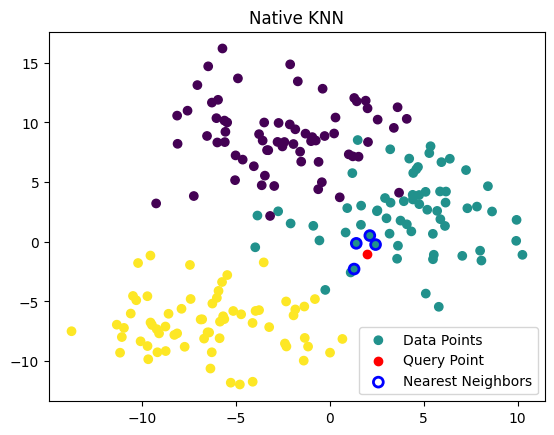

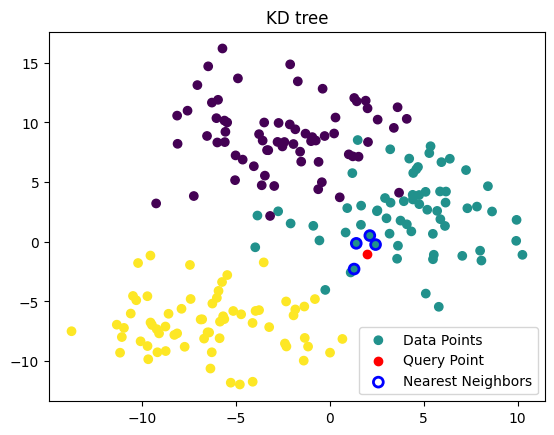

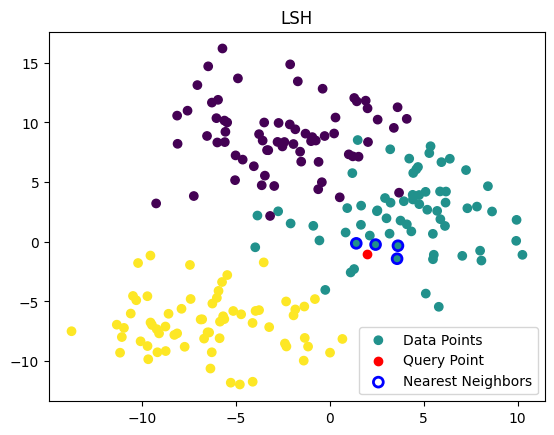

In [80]:
show(data,query,nearest_neighbors_naive,y , "Native KNN")
show(data,query,nearest_neighbors_kdtree,y,"KD tree")
show(data,query,nearest_neighbors_lsh,y, "LSH")

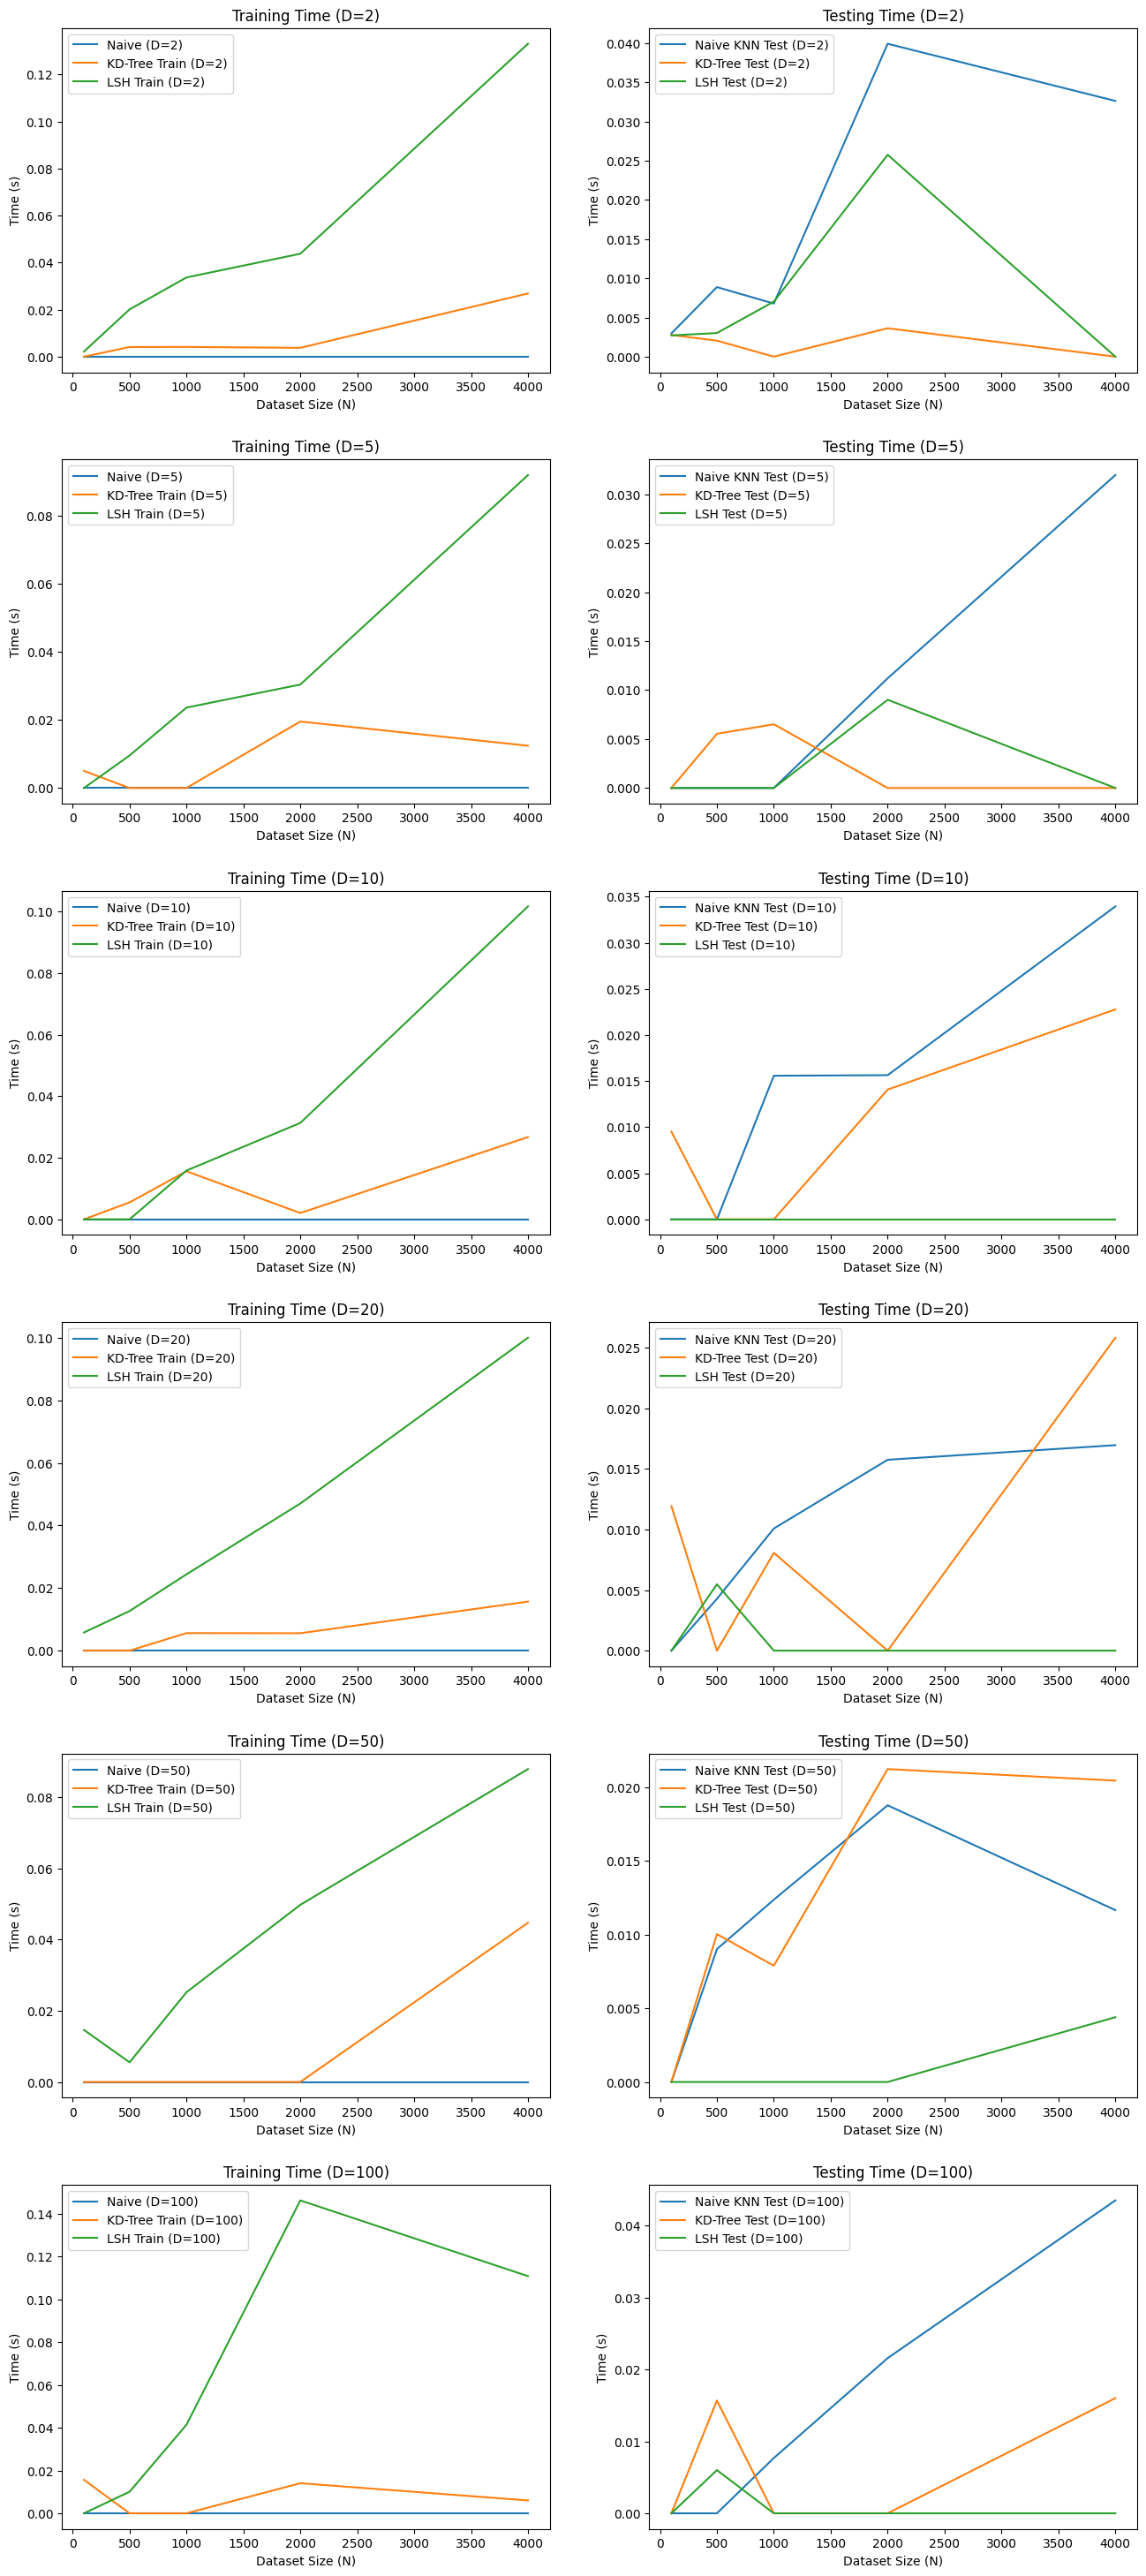

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Assuming KDTree, LSH, and knn_naive functions or classes are defined elsewhere.

def time_comparison(sizes, dimensions, k):
    naive_train_times, naive_test_times = [], []
    kd_train_times, kd_test_times = [], []
    lsh_train_times, lsh_test_times = [], []

    for D in dimensions:
        for N in sizes:
            # Generate random dataset
            data = np.random.rand(N, D)
            query = np.random.rand(D)
            y = [0] * N
            
            # Training time for KD-Tree
            start = time.time()
            kdtree = KDTree(data, y)
            kd_train_time = time.time() - start

            # Testing time for KD-Tree
            start = time.time()
            kdtree.knn_kdtree(query, k)
            kd_test_time = time.time() - start
            
            # Training time for LSH
            start = time.time()
            lsh = LSH(data, y)
            lsh_train_time = time.time() - start

            # Testing time for LSH
            start = time.time()
            lsh.knn_lsh(query, k)
            lsh_test_time = time.time() - start
            
            # Testing time for Naive KNN (no training required)
            start = time.time()
            knn_naive(data, y, query, k)
            naive_test_time = time.time() - start

            # Append results
            naive_train_times.append((N, D, 0))  # No training for naive
            naive_test_times.append((N, D, naive_test_time))

            kd_train_times.append((N, D, kd_train_time))
            kd_test_times.append((N, D, kd_test_time))

            lsh_train_times.append((N, D, lsh_train_time))
            lsh_test_times.append((N, D, lsh_test_time))
    
    # Plot results
    fig, axs = plt.subplots(len(dimensions), 2, figsize=(14, 5 * len(dimensions)))
    fig.tight_layout(pad=5.0)

    for i, D in enumerate(dimensions):
        # Filter times for current dimension
        naive_test_times_d = [t[2] for t in naive_test_times if t[1] == D]
        kd_train_times_d = [t[2] for t in kd_train_times if t[1] == D]
        kd_test_times_d = [t[2] for t in kd_test_times if t[1] == D]
        lsh_train_times_d = [t[2] for t in lsh_train_times if t[1] == D]
        lsh_test_times_d = [t[2] for t in lsh_test_times if t[1] == D]

        # Training time plot
        axs[i, 0].plot(sizes, [0] * len(sizes), label=f'Naive (D={D})')  # Naive has no training time
        axs[i, 0].plot(sizes, kd_train_times_d, label=f'KD-Tree Train (D={D})')
        axs[i, 0].plot(sizes, lsh_train_times_d, label=f'LSH Train (D={D})')
        axs[i, 0].set_title(f'Training Time (D={D})')
        axs[i, 0].set_xlabel('Dataset Size (N)')
        axs[i, 0].set_ylabel('Time (s)')
        axs[i, 0].legend()

        # Testing time plot
        axs[i, 1].plot(sizes, naive_test_times_d, label=f'Naive KNN Test (D={D})')
        axs[i, 1].plot(sizes, kd_test_times_d, label=f'KD-Tree Test (D={D})')
        axs[i, 1].plot(sizes, lsh_test_times_d, label=f'LSH Test (D={D})')
        axs[i, 1].set_title(f'Testing Time (D={D})')
        axs[i, 1].set_xlabel('Dataset Size (N)')
        axs[i, 1].set_ylabel('Time (s)')
        axs[i, 1].legend()

    plt.show()


# Run comparisons
sizes = [100, 500, 1000, 2000, 4000]
dimensions = [2, 5, 10, 20, 50, 100]
k = 3
time_comparison(sizes, dimensions, k)


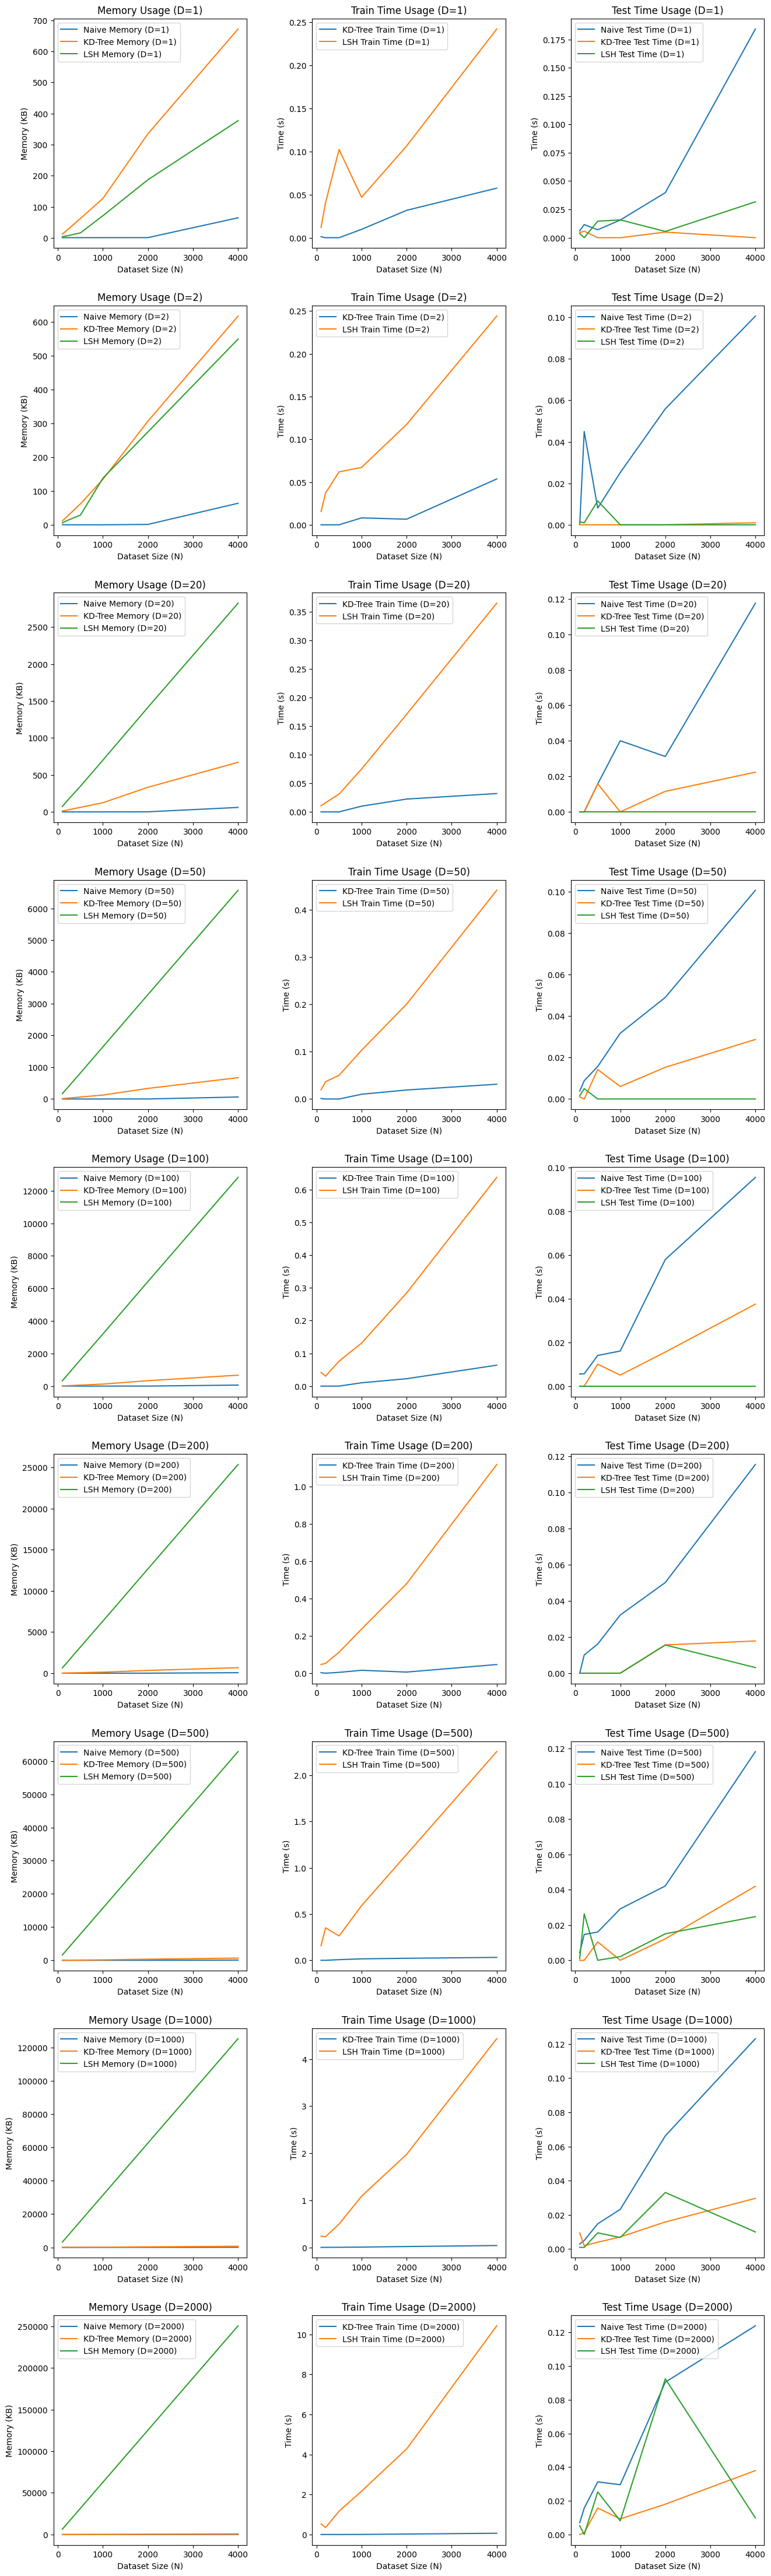

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc

# Assuming KDTree, LSH, and knn_naive functions or classes are defined elsewhere.

def memory_time_comparison(sizes, dimensions, k):
    naive_times, kd_times, lsh_times = [], [], []
    naive_memories, kd_memories, lsh_memories = [], [], []
    
    for D in dimensions:
        for N in sizes:
            # Generate random dataset
            data = np.random.rand(N, D)
            query = np.random.rand(D)
            y = [0] * N
            
            # Time and memory tracking for KD-Tree
            tracemalloc.start()
            start = time.time()
            kdtree = KDTree(data, y)
            kd_train_time = time.time() - start
            kd_memory, _ = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            start = time.time()
            kdtree.knn_kdtree(query, k)
            kd_test_time = time.time() - start
            kd_times.append((N, D, kd_train_time, kd_test_time))
            kd_memories.append((N, D, kd_memory))
            
            # Time and memory tracking for LSH
            tracemalloc.start()
            start = time.time()
            lsh = LSH(data, y)
            lsh_train_time = time.time() - start
            lsh_memory, _ = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            start = time.time()
            lsh.knn_lsh(query, k)
            lsh_test_time = time.time() - start
            lsh_times.append((N, D, lsh_train_time, lsh_test_time))
            lsh_memories.append((N, D, lsh_memory))

            # Time and memory tracking for Naive KNN
            tracemalloc.start()
            start = time.time()
            knn_naive(data, y, query, k)
            naive_test_time = time.time() - start
            naive_memory, _ = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            naive_times.append((N, D, 0, naive_test_time))  # No training for naive
            naive_memories.append((N, D, naive_memory))
    
    # Plot results for memory and time
    fig, axs = plt.subplots(len(dimensions), 3, figsize=(14, 5 * len(dimensions)))
    fig.tight_layout(pad=5.0)

    for i, D in enumerate(dimensions):
        # Filter times and memory for current dimension
        naive_times_d = [t[3] for t in naive_times if t[1] == D]
        kd_train_times_d = [t[2] for t in kd_times if t[1] == D]
        kd_test_times_d = [t[3] for t in kd_times if t[1] == D]
        lsh_train_times_d = [t[2] for t in lsh_times if t[1] == D]
        lsh_test_times_d = [t[3] for t in lsh_times if t[1] == D]

        naive_memories_d = [m[2] / 1024 for m in naive_memories if m[1] == D]  # Convert to KB
        kd_memories_d = [m[2] / 1024 for m in kd_memories if m[1] == D]
        lsh_memories_d = [m[2] / 1024 for m in lsh_memories if m[1] == D]

        # Plot memory usage
        axs[i, 0].plot(sizes, naive_memories_d, label=f'Naive Memory (D={D})')
        axs[i, 0].plot(sizes, kd_memories_d, label=f'KD-Tree Memory (D={D})')
        axs[i, 0].plot(sizes, lsh_memories_d, label=f'LSH Memory (D={D})')
        axs[i, 0].set_title(f'Memory Usage (D={D})')
        axs[i, 0].set_xlabel('Dataset Size (N)')
        axs[i, 0].set_ylabel('Memory (KB)')
        axs[i, 0].legend()

        # Plot time usage
        # axs[i, 1].plot(sizes, naive_times_d, label=f'Naive Test Time (D={D})')
        axs[i, 1].plot(sizes, kd_train_times_d, label=f'KD-Tree Train Time (D={D})')
        # axs[i, 1].plot(sizes, kd_test_times_d, label=f'KD-Tree Test Time (D={D})')
        axs[i, 1].plot(sizes, lsh_train_times_d, label=f'LSH Train Time (D={D})')
        # axs[i, 1].plot(sizes, lsh_test_times_d, label=f'LSH Test Time (D={D})')
        axs[i, 1].set_title(f'Train Time Usage (D={D})')
        axs[i, 1].set_xlabel('Dataset Size (N)')
        axs[i, 1].set_ylabel('Time (s)')
        axs[i, 1].legend()

        axs[i, 2].plot(sizes, naive_times_d, label=f'Naive Test Time (D={D})')
        axs[i, 2].plot(sizes, kd_test_times_d, label=f'KD-Tree Test Time (D={D})')
        axs[i, 2].plot(sizes, lsh_test_times_d, label=f'LSH Test Time (D={D})')
        axs[i, 2].set_title(f'Test Time Usage (D={D})')
        axs[i, 2].set_xlabel('Dataset Size (N)')
        axs[i, 2].set_ylabel('Time (s)')
        axs[i, 2].legend()

    plt.show()


# Run comparisons
sizes = [100, 200, 500, 1000, 2000, 4000]
dimensions = [1,2, 20, 50, 100, 200, 500, 1000, 2000]
k = 3
memory_time_comparison(sizes, dimensions, k)


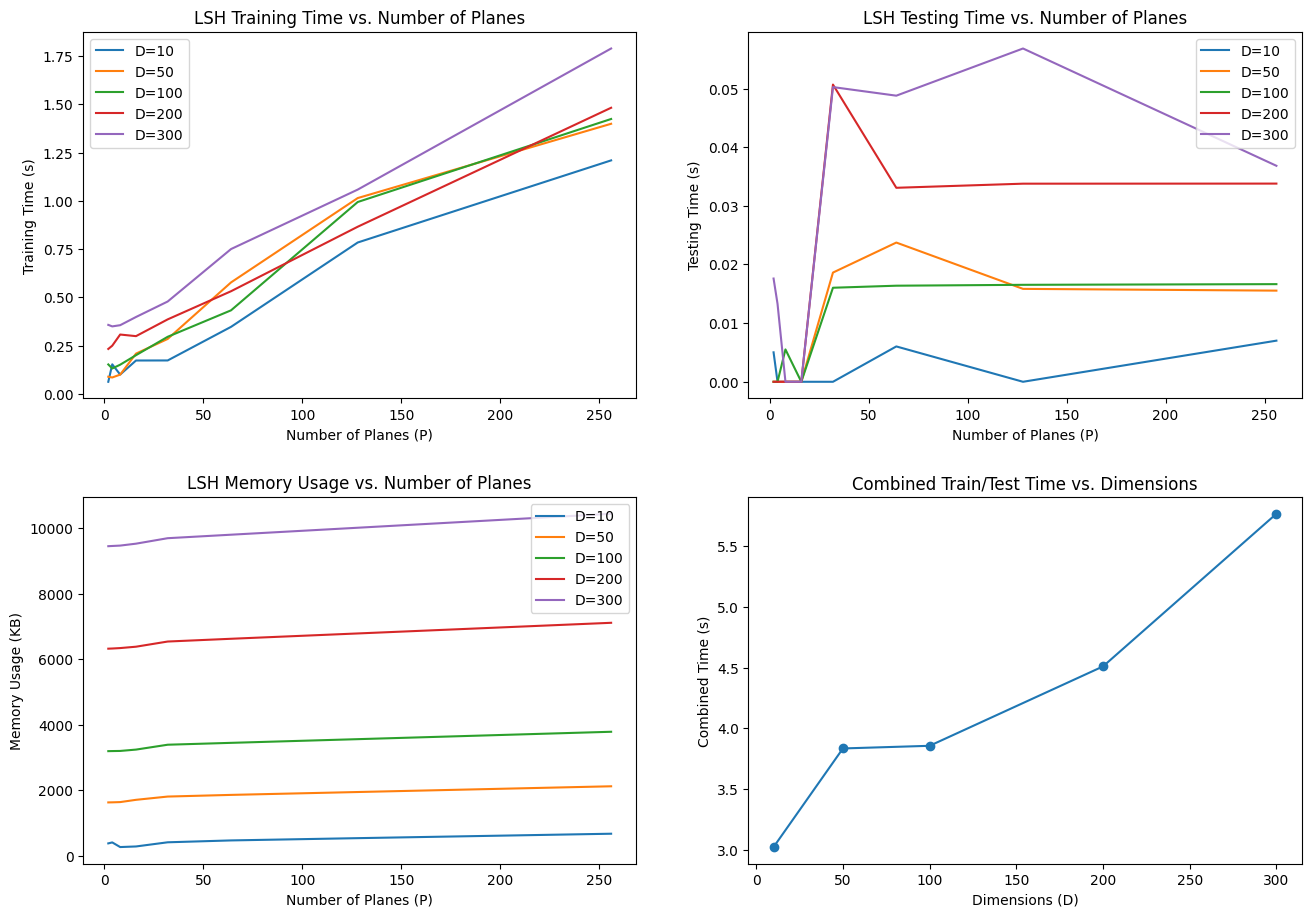

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc
from collections import defaultdict

# Assuming LSH class is defined as provided in the previous responses

def memory_time_comparison(planes, dimensions, k):
    lsh_times, lsh_memories = [], []

    for D in dimensions:
        for P in planes:
            # Generate random dataset with size N = 1000 and D dimensions
            N = 1000
            data = np.random.rand(N, D)
            query = np.random.rand(D)
            y = np.random.randint(0, 2, N)

            # Track memory and time for LSH
            tracemalloc.start()
            start = time.time()
            lsh = LSH(data, y, num_planes=P)
            lsh_train_time = time.time() - start
            lsh_memory, _ = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            # Measure testing time for LSH
            start = time.time()
            lsh.knn_lsh(query, k)
            lsh_test_time = time.time() - start

            # Store results
            lsh_times.append((P, D, lsh_train_time, lsh_test_time))
            lsh_memories.append((P, D, lsh_memory / 1024))  # Convert memory to KB

    # Plot results for LSH only
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.tight_layout(pad=5.0)

    for D in dimensions:
        # Filter times and memory for current dimension
        train_times_d = [t[2] for t in lsh_times if t[1] == D]
        test_times_d = [t[3] for t in lsh_times if t[1] == D]
        memories_d = [m[2] for m in lsh_memories if m[1] == D]

        # Plot training time vs. number of planes
        axs[0, 0].plot(planes, train_times_d, label=f'D={D}')
        axs[0, 0].set_title('LSH Training Time vs. Number of Planes')
        axs[0, 0].set_xlabel('Number of Planes (P)')
        axs[0, 0].set_ylabel('Training Time (s)')
        axs[0, 0].legend()

        # Plot testing time vs. number of planes
        axs[0, 1].plot(planes, test_times_d, label=f'D={D}')
        axs[0, 1].set_title('LSH Testing Time vs. Number of Planes')
        axs[0, 1].set_xlabel('Number of Planes (P)')
        axs[0, 1].set_ylabel('Testing Time (s)')
        axs[0, 1].legend()

        # Plot memory usage vs. number of planes
        axs[1, 0].plot(planes, memories_d, label=f'D={D}')
        axs[1, 0].set_title('LSH Memory Usage vs. Number of Planes')
        axs[1, 0].set_xlabel('Number of Planes (P)')
        axs[1, 0].set_ylabel('Memory Usage (KB)')
        axs[1, 0].legend()

    # Plot combined train/test time with increasing dimensions
    combined_times = []
    for D in dimensions:
      combined_times += [(D, t[2] + t[3]) for t in lsh_times if t[1] == D]
    dimensions_unique = sorted(set(dimensions))
    combined_time_values = [sum(t[1] for t in combined_times if t[0] == D) for D in dimensions_unique]
    axs[1, 1].plot(dimensions_unique, combined_time_values, marker='o')
    axs[1, 1].set_title('Combined Train/Test Time vs. Dimensions')
    axs[1, 1].set_xlabel('Dimensions (D)')
    axs[1, 1].set_ylabel('Combined Time (s)')

    plt.show()

# Run comparisons
planes = [2, 4, 8, 16, 32, 64, 128, 256]
dimensions = [10, 50, 100, 200, 300]
k = 3
memory_time_comparison(planes, dimensions, k)


Dim: 3, KDTree Accuracy: 0.66, LSH Accuracy: 0.62, Naive KNN Accuracy: 0.66
Dim: 103, KDTree Accuracy: 1.0, LSH Accuracy: 0.95, Naive KNN Accuracy: 1.0
Dim: 203, KDTree Accuracy: 1.0, LSH Accuracy: 0.95, Naive KNN Accuracy: 1.0
Dim: 303, KDTree Accuracy: 1.0, LSH Accuracy: 0.85, Naive KNN Accuracy: 1.0
Dim: 403, KDTree Accuracy: 1.0, LSH Accuracy: 0.99, Naive KNN Accuracy: 1.0
Dim: 503, KDTree Accuracy: 1.0, LSH Accuracy: 0.94, Naive KNN Accuracy: 1.0
Dim: 603, KDTree Accuracy: 1.0, LSH Accuracy: 0.92, Naive KNN Accuracy: 1.0
Dim: 703, KDTree Accuracy: 1.0, LSH Accuracy: 0.91, Naive KNN Accuracy: 1.0
Dim: 803, KDTree Accuracy: 1.0, LSH Accuracy: 0.91, Naive KNN Accuracy: 1.0
Dim: 903, KDTree Accuracy: 1.0, LSH Accuracy: 0.92, Naive KNN Accuracy: 1.0


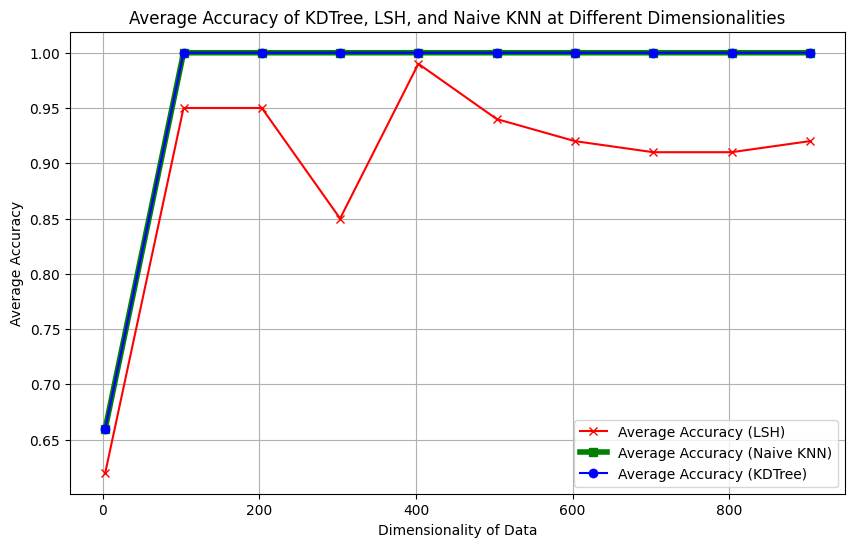

In [111]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming KDTree, LSH, and knn_naive are already defined

k = 3
dim = range(3, 1000, 100)
num_queries = 100  # Number of test query points for accuracy calculation

# Lists to store average accuracy for each dimension
average_accuracy_kd_list = []
average_accuracy_lsh_list = []
average_accuracy_naive_list = []

for d in dim:
    # Generate dataset
    dataset = make_blobs(n_samples=1000, n_features=d,centers=10, random_state=42)
    x, y = dataset
    x = x + np.random.normal(loc=0, scale=3, size=x.shape)
    
    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=num_queries, random_state=42)
    
    # Initialize the models with training data
    kdtree = KDTree(x_train, y_train)
    lsh = LSH(x_train, y_train)
    
    # Lists to store predicted labels for each test query point
    kd_pred_labels = []
    lsh_pred_labels = []
    naive_pred_labels = []
    
    # Perform KNN searches on the test set
    for query in x_test:
        # Perform KNN searches using each method
        _, kd_label = kdtree.knn_kdtree(query, k)
        _, lsh_label = lsh.knn_lsh(query, k)
        _, naive_label = knn_naive(x_train, y_train, query, k)
        
        # Append the predicted labels for each method
        kd_pred_labels.append(kd_label)
        lsh_pred_labels.append(lsh_label)
        naive_pred_labels.append(naive_label)
    
    # Calculate accuracy for each method
    accuracy_kd = accuracy_score(y_test, kd_pred_labels)
    accuracy_lsh = accuracy_score(y_test, lsh_pred_labels)
    accuracy_naive = accuracy_score(y_test, naive_pred_labels)
    
    # Append the average accuracy values to the lists
    average_accuracy_kd_list.append(accuracy_kd)
    average_accuracy_lsh_list.append(accuracy_lsh)
    average_accuracy_naive_list.append(accuracy_naive)
    
    # Optionally print the results for debugging
    print(f"Dim: {d}, KDTree Accuracy: {accuracy_kd}, LSH Accuracy: {accuracy_lsh}, Naive KNN Accuracy: {accuracy_naive}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(dim, average_accuracy_lsh_list, label='Average Accuracy (LSH)', marker='x', color='r')
plt.plot(dim, average_accuracy_naive_list, label='Average Accuracy (Naive KNN)', marker='s', color='g',linewidth=4)
plt.plot(dim, average_accuracy_kd_list, label='Average Accuracy (KDTree)', marker='o', color='b')

# Adding labels and title
plt.xlabel('Dimensionality of Data')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy of KDTree, LSH, and Naive KNN at Different Dimensionalities')
plt.legend()
plt.grid(True)
plt.show()


In [88]:
average_accuracy_naive_list

[0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [53]:
naive_label, kd_label, lsh_label

(1, 1, 1)


| Method       | Expected Time per Query  | Efficiency for Dimensions |
|--------------|--------------------------|---------------------------|
| **Naive KNN** | Slow  | Works for small data; slow on high-dimensional |
| **LSH KNN**   | Moderate  | Best for high-dimensional data |
| **KD-Tree KNN** | Fast in low-dim ; slower in high-dim | Ideal for low-dimensional data |
